In [1]:
""" initialize the notebook """

%matplotlib inline
import pylab as PP # load the plotting library
import matplotlib as mpl 
from numpy import *
import netCDF4 as nc # load the netCDF library
import scipy.io as sio
import pandas as pd
from scipy.fftpack import fft, ifft
from mpl_toolkits.basemap import Basemap # Library to plot 2D maps in Python
from IPython.display import Image # Library to attach images inside a code cell in Jupyter
import zipfile # library to compress and uncompress files (zip)
import urllib # library to download files
from matplotlib.collections import PatchCollection # for efficiently drawing many polygons
import os.path # to ckeck if a file exists
import datetime as dt # import the datetime libarary for date handling

#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)

In [3]:
fileslp = r'slp.mon.mean.nc'
filesst = r'air.mon.mean.nc'

with nc.Dataset(fileslp,'r') as fin:
#      print fin.variables
     slp_var = fin.variables['slp']
     slp=slp_var[:]
     lat = fin.variables['lat'][:]
     lon = fin.variables['lon'][:]
     time= fin.variables['time'][:]
with nc.Dataset(filesst,'r') as fin:
#      print fin.variables
     sst_var = fin.variables['air']
     sst=sst_var[:]

In [4]:
indx = nonzero((lon >= 170) & (lon <= 240 ))[0]
indy = nonzero( (lat >= 0 ) & (lat <= 60))[0]

indxx, indyy = meshgrid(indx,indy)

In [5]:
slp=slp[:,indyy,indxx]
sst=sst[:,indyy,indxx]
lon=lon[indxx]
lat=lat[indyy]

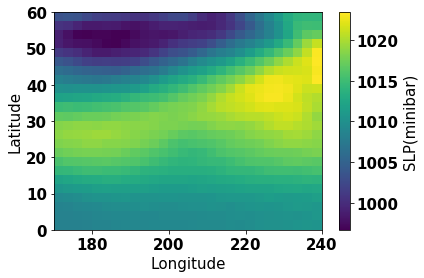

In [6]:
first_slp = slp[0,:,:]

fig,ax = PP.subplots()
# and plot the slp array
cplt = ax.pcolormesh(lon,lat,first_slp)
# plot a colorbar
fig.colorbar(cplt,label='SLP(minibar)')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
PP.show()

In [7]:
# slp_eof=slp.reshape([832,-1])

In [8]:
# dates=nc.num2date(time,"hours since 1800-01-01 00:00:0.0")

In [9]:
# write a function to determine if an array is empty 
# def isEmpty(self):
#         if self.items == []:
# #             return true
#         else:
#             return false

In [10]:
# # write a function to calculate EOF

# def EOF(d,toler, meanflag=0):
#     """
#     compute the EOFs from the mean square (or convariance) matrix of a dataset with potential missing data. 
#     The default is remove means from obeservation time series and compute the covariance matrix.
    
#     input
#     d --- The data matrix, M columns (spatial locations), N rows (time)
#     toler --- Defines acceptable upper limit of expected square error
#     meanflag --- Optional input variables. if 0(default)  means are to be removed from time series to calculate covariance. 
#                  If meanflag has any other value, then the means are not removed and mean square matrix is computed
                 
#     output
    
#     F The orthonormal EOF eigenvectors
#     a The EOF amplitude time series matrix, normalized to give mean square of the EOF mode, with renormalized eigenvectors.
#     l The eigenvalues of the EOFs (column vector length M)
#     err The expected percent square error at each time for each of the EOF amplitude time series estimates.
#         err is 0 if there is no missing data.
    
#     """
    
#     [N,M]=shape(d)
#     if meanflag == 0:
#         d=d-ones((N,1))*nanmean(d,axis=0)
    
#     #calculate mean square (or covariance) matrix
    
#     D=zeros((M,M))
#     for ir in range(M) :
#         D[ir,ir]=nanmean(d[:,ir]*d[:,ir])
#         for ic in range (ir+1,M):
#             D[ir,ic] = nanmean (d[:,ir]*d[:,ir])
#             D[ic,ir] =D[ir,ic]
    
#     # Decompose into singular matrices:
#     # F are orthonormal eigen vectors
#     W,l,F = linalg.svd (D,full_matrices=False)
    
#     # get variance for each mode 
#     l=diag(l);
    
#     #calculate the amplitude functions
#     a =dot(d,F)
#     err=zeros(shape(a))
    
#     #find missing values in a 
#     nnan=where(isnan(sum(transpose(a))))
    
# #     if not isEmpty(nnan):
#     for idn in range(0,len(nnan)-1):
#             n=nnan(idn)
#             for ik in range(M):
#                 ms=where(isnan(d[n,:])) # missing data index
#                 mm=where(logical_not(nan(d[n,:]))) #non-missing data index
#                 gkj=dot(transpose(F[ms,ik]),F[ms,:])
#                 Gk=((gkj(ik)-1)**2)*l(ik)+(gkj^2)*l-l(ik)*(gkj(ik)**2)
#                 bk=(1-gkj(ik))/Gk
#                 err[n,ik]=bk;
#                 if bk<=toler:
#                     a[n,ik]=bk*l(ik)*(dot(d[n,mm],F[mm,ik]))
#                 else:
#                     a[n,ik]= NaN  
  
#     return F,a,l,err

                

In [11]:
# F,a,l,err = EOF(slp_eof,0.5)

In [12]:
def alternate_eof(matrix, nmax = None):
    """
        input:
        ------
            matrix : a 3D matrix with dimensions [time,lat,lon]
            
            nmax : the maximum eigenvector/value to return (default is all)
            
        output:
        -------
        
            pca, eof : the eigenvalue and eigenvectors of the correlation matrix of `matrix`, ordered by eigenvalue (descending)
    
    """
    
    # calculate correlation matrix
    corr_matrix = corrcoef(matrix.reshape([matrix.shape[0],-1]),rowvar=0)
    
    # do eigenvalue/vector decomposition of the correlation matrix
    eigenvalues, eigenvectors = linalg.eigh(corr_matrix)
    
    # order the eigenvectors/values by eigenvalue
    isort = argsort(eigenvalues)[::-1]
    if nmax is not None:
        isort = isort[:nmax]
    
    eof_timeseries = dot(eigenvectors, matrix.reshape([matrix.shape[0],-1]).T)
    
    # reshape the eigenvectors into lat/lon patterns
    eigenvectors = reshape(eigenvectors.T,[eigenvectors.shape[1],matrix.shape[1],matrix.shape[2]])

    # normalize eigenvalues
    eigenvalues = eigenvalues / sum(eigenvalues**2)
    
    # renormalize the timeseries
    ##eof_timeseries =  dot(eigenvalues).T
    
    # return sorted version
    return eigenvalues[isort], eigenvectors[isort,:,:], eof_timeseries[isort,:]

In [13]:
slp_eigvals, slp_eigvectors, slpeof_ts = alternate_eof(slp,10)
sst_eigvals, sst_eigvectors, ssteof_ts = alternate_eof(sst,10)

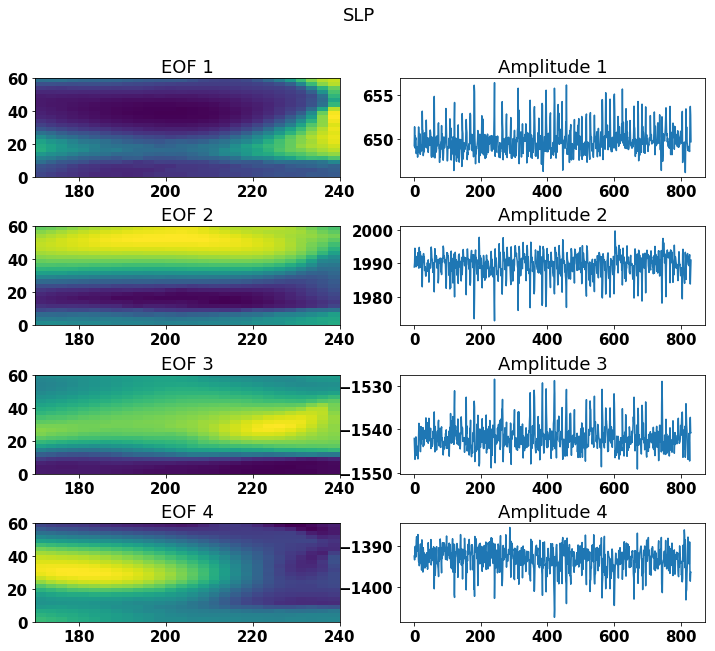

In [14]:
#plot leading 4 EOF modes for SLP and corresponding temporal amplitude for each mode

fig = PP.figure(figsize=(12, 10))
fig.subplots_adjust(hspace=.5)
PP.suptitle('SLP')
sub1 = fig.add_subplot(421) # instead of plt.subplot(2, 2, 1)
sub1.set_title('EOF 1') # non OOP: plt.title('The function f')
sub1.pcolormesh(lon,lat,slp_eigvectors[0,...])
#PP.colorbar()
# PP.show()

sub2 = fig.add_subplot(422) # instead of plt.subplot(2, 2, 1)
sub2.set_title('Amplitude 1') # non OOP: plt.title('The function f')
sub2.plot(slpeof_ts[0])

sub3 = fig.add_subplot(423) # instead of plt.subplot(2, 2, 1)
sub3.set_title('EOF 2') # non OOP: plt.title('The function f')
sub3.pcolormesh(lon,lat,slp_eigvectors[1,...])
#PP.colorbar()
# PP.show()

sub4 = fig.add_subplot(424) # instead of plt.subplot(2, 2, 1)
sub4.set_title('Amplitude 2') # non OOP: plt.title('The function f')
sub4.plot(slpeof_ts[1])

sub5 = fig.add_subplot(425) # instead of plt.subplot(2, 2, 1)
sub5.set_title('EOF 3') # non OOP: plt.title('The function f')
sub5.pcolormesh(lon,lat,slp_eigvectors[2,...])
#PP.colorbar()
# PP.show()

sub6 = fig.add_subplot(426) # instead of plt.subplot(2, 2, 1)
sub6.set_title('Amplitude 3') # non OOP: plt.title('The function f')
sub6.plot(slpeof_ts[2])

sub7 = fig.add_subplot(427) # instead of plt.subplot(2, 2, 1)
sub7.set_title('EOF 4') # non OOP: plt.title('The function f')
sub7.pcolormesh(lon,lat,slp_eigvectors[3,...])
#PP.colorbar()
# PP.show()

sub8 = fig.add_subplot(428) # instead of plt.subplot(2, 2, 1)
sub8.set_title('Amplitude 4') # non OOP: plt.title('The function f')
sub8.plot(slpeof_ts[3])

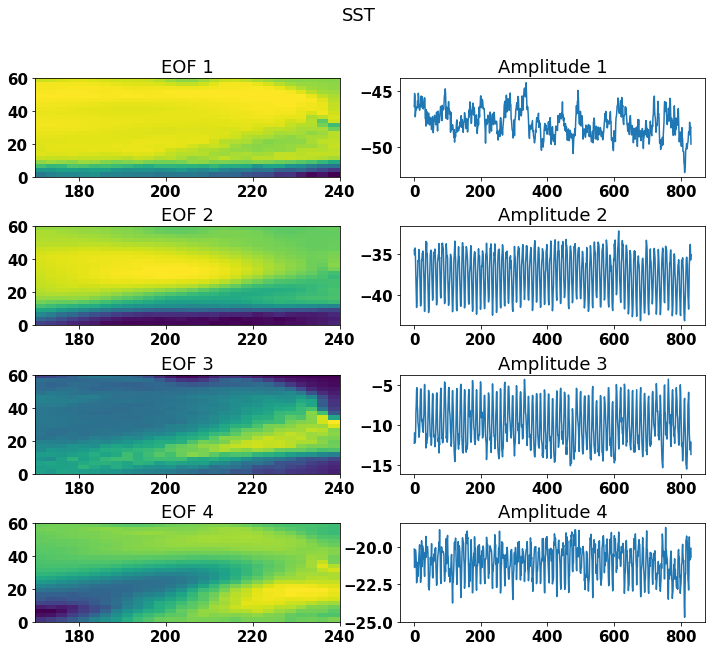

In [15]:
#plot leading 4 EOF modes for SST and corresponding temporal amplitude for each mode

fig = PP.figure(figsize=(12, 10))
fig.subplots_adjust(hspace=.5)
PP.suptitle('SST')
sub1 = fig.add_subplot(421) # instead of plt.subplot(2, 2, 1)
sub1.set_title('EOF 1') # non OOP: plt.title('The function f')
sub1.pcolormesh(lon,lat,sst_eigvectors[0,...])
#PP.colorbar()
# PP.show()

sub2 = fig.add_subplot(422) # instead of plt.subplot(2, 2, 1)
sub2.set_title('Amplitude 1') # non OOP: plt.title('The function f')
sub2.plot(ssteof_ts[0])

sub3 = fig.add_subplot(423) # instead of plt.subplot(2, 2, 1)
sub3.set_title('EOF 2') # non OOP: plt.title('The function f')
sub3.pcolormesh(lon,lat,sst_eigvectors[1,...])
#PP.colorbar()
# PP.show()

sub4 = fig.add_subplot(424) # instead of plt.subplot(2, 2, 1)
sub4.set_title('Amplitude 2') # non OOP: plt.title('The function f')
sub4.plot(ssteof_ts[1])

sub5 = fig.add_subplot(425) # instead of plt.subplot(2, 2, 1)
sub5.set_title('EOF 3') # non OOP: plt.title('The function f')
sub5.pcolormesh(lon,lat,sst_eigvectors[2,...])
#PP.colorbar()
# PP.show()

sub6 = fig.add_subplot(426) # instead of plt.subplot(2, 2, 1)
sub6.set_title('Amplitude 3') # non OOP: plt.title('The function f')
sub6.plot(ssteof_ts[2])

sub7 = fig.add_subplot(427) # instead of plt.subplot(2, 2, 1)
sub7.set_title('EOF 4') # non OOP: plt.title('The function f')
sub7.pcolormesh(lon,lat,sst_eigvectors[3,...])
#PP.colorbar()
# PP.show()

sub8 = fig.add_subplot(428) # instead of plt.subplot(2, 2, 1)
sub8.set_title('Amplitude 4') # non OOP: plt.title('The function f')
sub8.plot(ssteof_ts[3])

In [16]:
def crosscorr(X, Y, a, b):
    """
        input:
        ------
            X Y: two vectors
            
            a b: the lower and upper bounds of the lags, a<0, b>0
            
        output:
        -------
        
            C : the correlation coefficient of vectors X and Y
            positive lags represent the influence of X on Y
            negative lags represent the influence of Y on X
    
    """
    
    l = len(X);
    C = zeros([b-a+1,1])


    for i in range(-a):
        yy=Y[1:l-i]
        xx=X[1+i:l]
        nn=where(logical_not(isnan(yy*xx)))
        norm=len(nn)
        Rxy=sum((yy[nn]-mean(yy[nn]))*(xx[nn]-mean(xx[nn])))/norm
        Rxx=sum((xx[nn]-mean(xx[nn]))**2)/norm
        Ryy=sum((yy[nn]-mean(yy[nn]))**2)/norm

        C[-a-i+1]=Rxy/sqrt(Rxx*Ryy)
       
    
    for i in range(b):

        xx=X[1:l-i]
        yy=Y[1+i:l]
        nn=where(logical_not(isnan(yy*xx)))
        norm=len(nn)
        Rxy=sum((xx[nn]-mean(xx[nn]))*(yy[nn]-mean(yy[nn])))/norm
        Rxx=sum((xx[nn]-mean(xx[nn]))**2)/norm
        Ryy=sum((yy[nn]-mean(yy[nn]))**2)/norm

        C[i+1-a]=Rxy/sqrt(Rxx*Ryy)


    
   
    return C


In [20]:
#Calculate the cross correlation between EOFs of SLP and SST
corr1_1=crosscorr(slpeof_ts[0],ssteof_ts[0],-10,10) #SLP EOF1 and SST EOF1
corr1_2=crosscorr(slpeof_ts[0],ssteof_ts[1],-10,10) #SLP EOF1 and SST EOF2
corr1_3=crosscorr(slpeof_ts[0],ssteof_ts[2],-10,10) #SLP EOF1 and SST EOF3
corr1_4=crosscorr(slpeof_ts[0],ssteof_ts[3],-10,10) #SLP EOF1 and SST EOF4
corr2_1=crosscorr(slpeof_ts[1],ssteof_ts[0],-10,10) #SLP EOF2 and SST EOF1
corr2_2=crosscorr(slpeof_ts[1],ssteof_ts[1],-10,10) #SLP EOF2 and SST EOF2
corr2_3=crosscorr(slpeof_ts[1],ssteof_ts[2],-10,10) #SLP EOF2 and SST EOF3
corr2_4=crosscorr(slpeof_ts[1],ssteof_ts[3],-10,10) #SLP EOF2 and SST EOF4
corr3_1=crosscorr(slpeof_ts[2],ssteof_ts[0],-10,10) #SLP EOF3 and SST EOF1
corr3_2=crosscorr(slpeof_ts[2],ssteof_ts[1],-10,10) #SLP EOF3 and SST EOF2
corr3_3=crosscorr(slpeof_ts[2],ssteof_ts[2],-10,10) #SLP EOF3 and SST EOF3
corr3_4=crosscorr(slpeof_ts[2],ssteof_ts[3],-10,10) #SLP EOF3 and SST EOF4
corr4_1=crosscorr(slpeof_ts[3],ssteof_ts[0],-10,10) #SLP EOF4 and SST EOF1
corr4_2=crosscorr(slpeof_ts[3],ssteof_ts[1],-10,10) #SLP EOF4 and SST EOF2
corr4_3=crosscorr(slpeof_ts[3],ssteof_ts[2],-10,10) #SLP EOF4 and SST EOF3
corr4_4=crosscorr(slpeof_ts[3],ssteof_ts[3],-10,10) #SLP EOF4 and SST EOF4

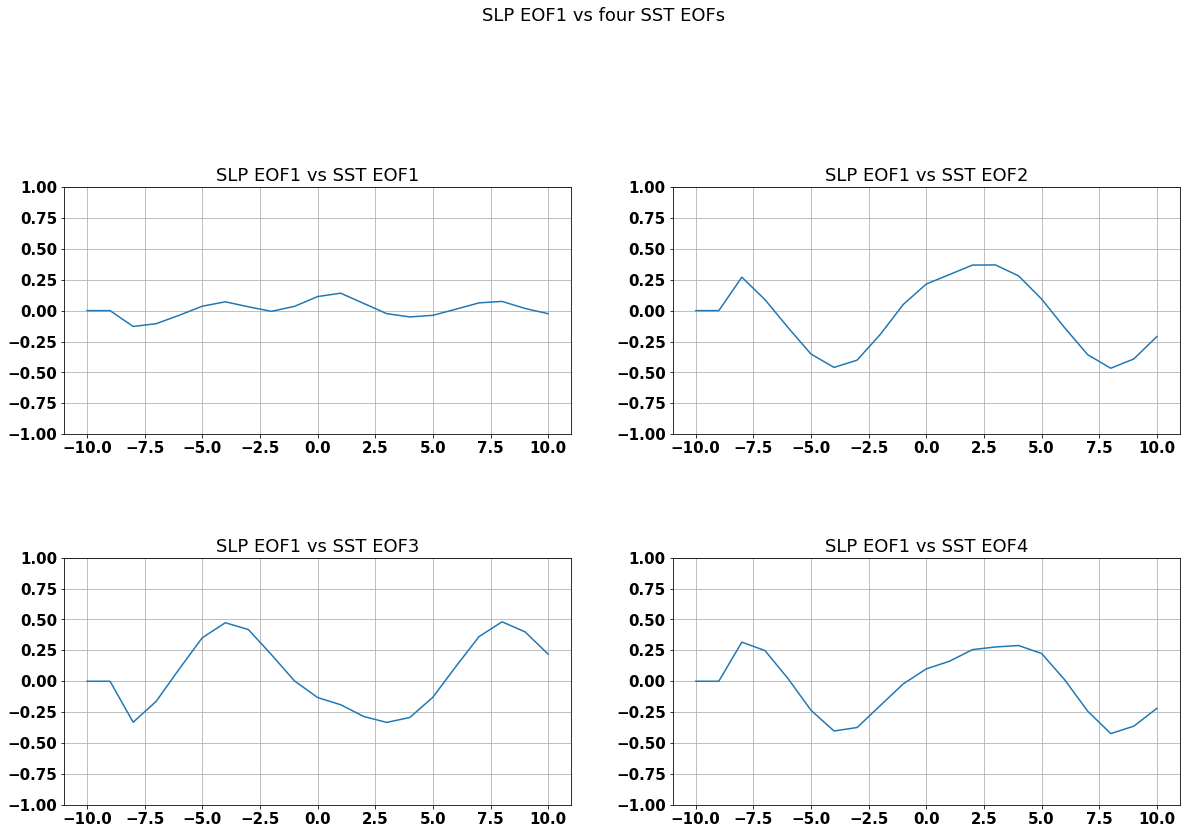

In [39]:
#Plot the cross correlation plot of SLP EOF1 with the four SST EOFs

fig = PP.figure(figsize=(20, 25))
fig.subplots_adjust(hspace=.5)
PP.suptitle('SLP EOF1 vs four SST EOFs')

sub1 = fig.add_subplot(421)
sub1.set_title('SLP EOF1 vs SST EOF1')
PP.plot(range(-10,11,1),corr1_1)
sub1.set_ylim([-1,1])
sub1.grid()

sub2 = fig.add_subplot(422)
sub2.set_title('SLP EOF1 vs SST EOF2')
PP.plot(range(-10,11,1),corr1_2)
sub2.set_ylim([-1,1])
sub2.grid()

sub3 = fig.add_subplot(423)
sub3.set_title('SLP EOF1 vs SST EOF3')
PP.plot(range(-10,11,1),corr1_3)
sub3.set_ylim([-1,1])
sub3.grid()

sub4 = fig.add_subplot(424)
sub4.set_title('SLP EOF1 vs SST EOF4')
PP.plot(range(-10,11,1),corr1_4)
sub4.set_ylim([-1,1])
sub4.grid()

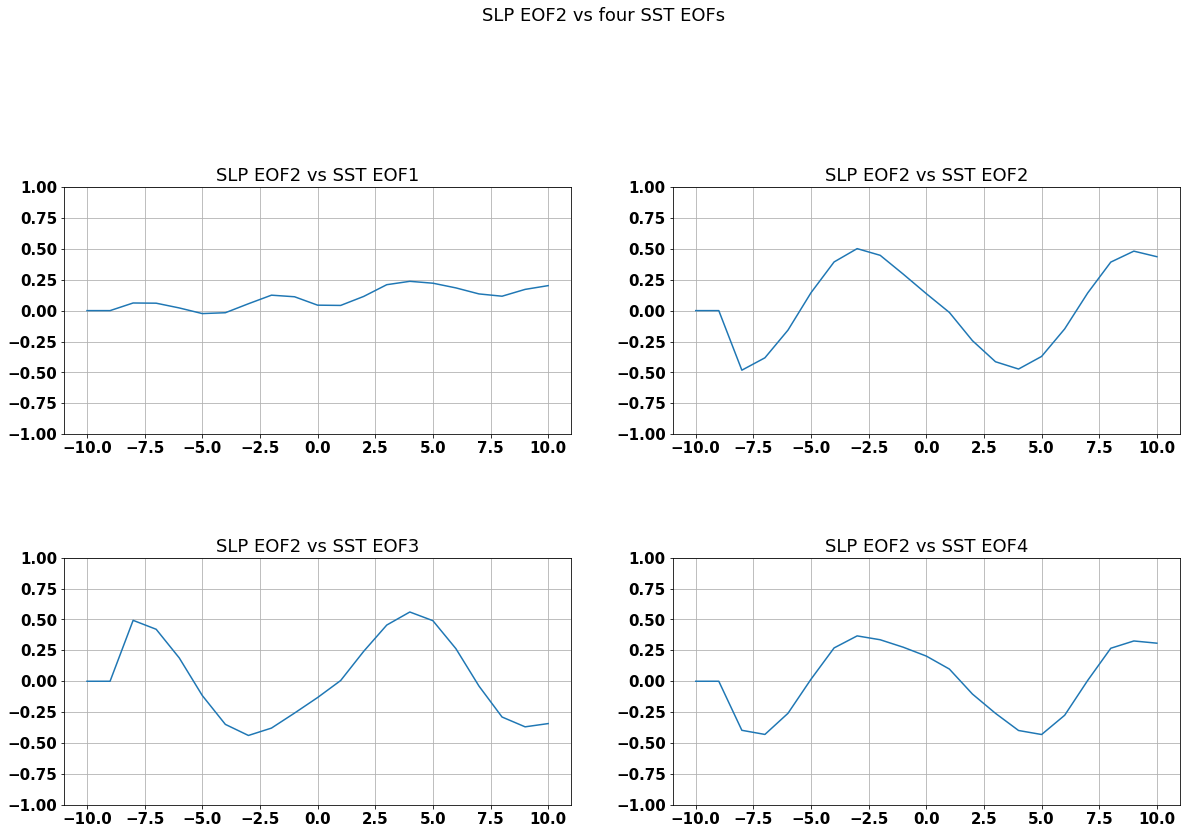

In [35]:
#Plot the cross correlation plot of SLP EOF2 with the four SST EOFs

fig = PP.figure(figsize=(20, 25))
fig.subplots_adjust(hspace=.5)
PP.suptitle('SLP EOF2 vs four SST EOFs')

sub1 = fig.add_subplot(421)
sub1.set_title('SLP EOF2 vs SST EOF1')
PP.plot(range(-10,11,1),corr2_1)
sub1.set_ylim([-1,1])
sub1.grid()

sub2 = fig.add_subplot(422)
sub2.set_title('SLP EOF2 vs SST EOF2')
PP.plot(range(-10,11,1),corr2_2)
sub2.set_ylim([-1,1])
sub2.grid()

sub3 = fig.add_subplot(423)
sub3.set_title('SLP EOF2 vs SST EOF3')
PP.plot(range(-10,11,1),corr2_3)
sub3.set_ylim([-1,1])
sub3.grid()

sub4 = fig.add_subplot(424)
sub4.set_title('SLP EOF2 vs SST EOF4')
PP.plot(range(-10,11,1),corr2_4)
sub4.set_ylim([-1,1])
sub4.grid()

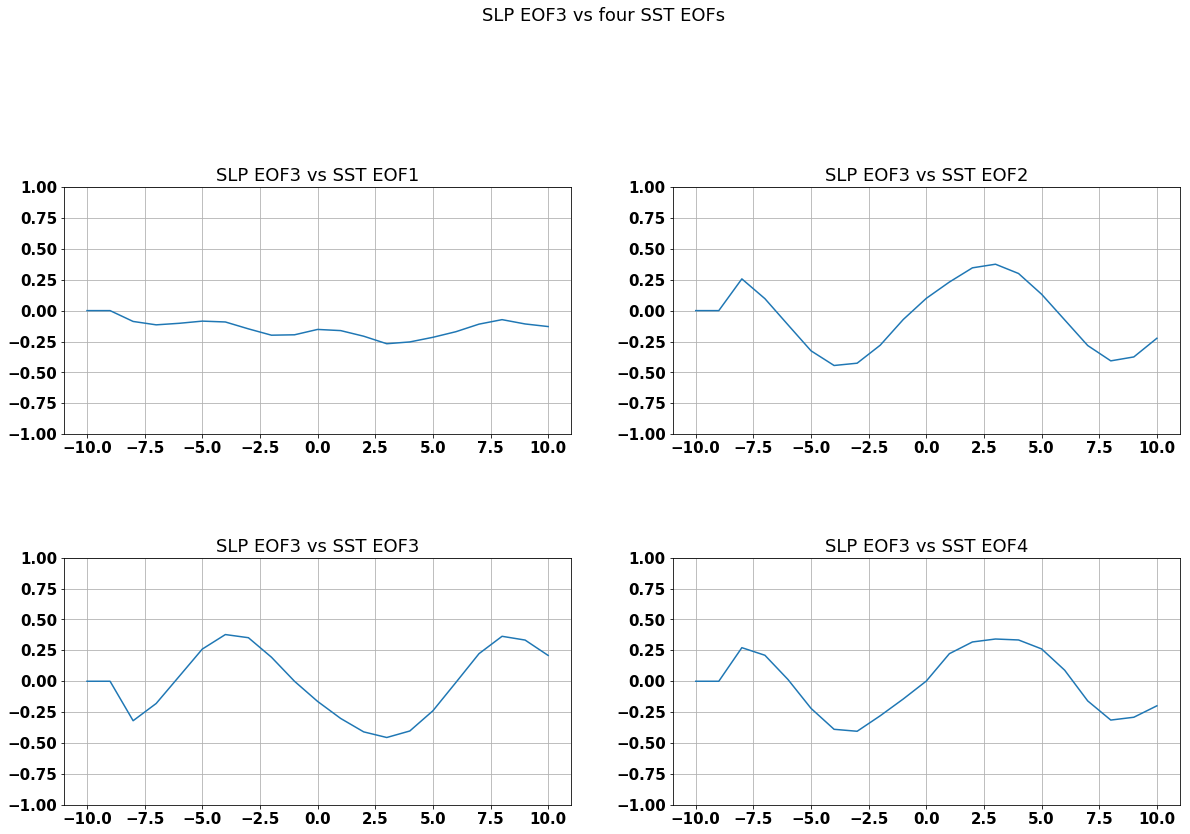

In [36]:
#Plot the cross correlation plot of SLP EOF3 with the four SST EOFs

fig = PP.figure(figsize=(20, 25))
fig.subplots_adjust(hspace=.5)
PP.suptitle('SLP EOF3 vs four SST EOFs')

sub1 = fig.add_subplot(421)
sub1.set_title('SLP EOF3 vs SST EOF1')
PP.plot(range(-10,11,1),corr3_1)
sub1.set_ylim([-1,1])
sub1.grid()

sub2 = fig.add_subplot(422)
sub2.set_title('SLP EOF3 vs SST EOF2')
PP.plot(range(-10,11,1),corr3_2)
sub2.set_ylim([-1,1])
sub2.grid()

sub3 = fig.add_subplot(423)
sub3.set_title('SLP EOF3 vs SST EOF3')
PP.plot(range(-10,11,1),corr3_3)
sub3.set_ylim([-1,1])
sub3.grid()

sub4 = fig.add_subplot(424)
sub4.set_title('SLP EOF3 vs SST EOF4')
PP.plot(range(-10,11,1),corr3_4)
sub4.set_ylim([-1,1])
sub4.grid()

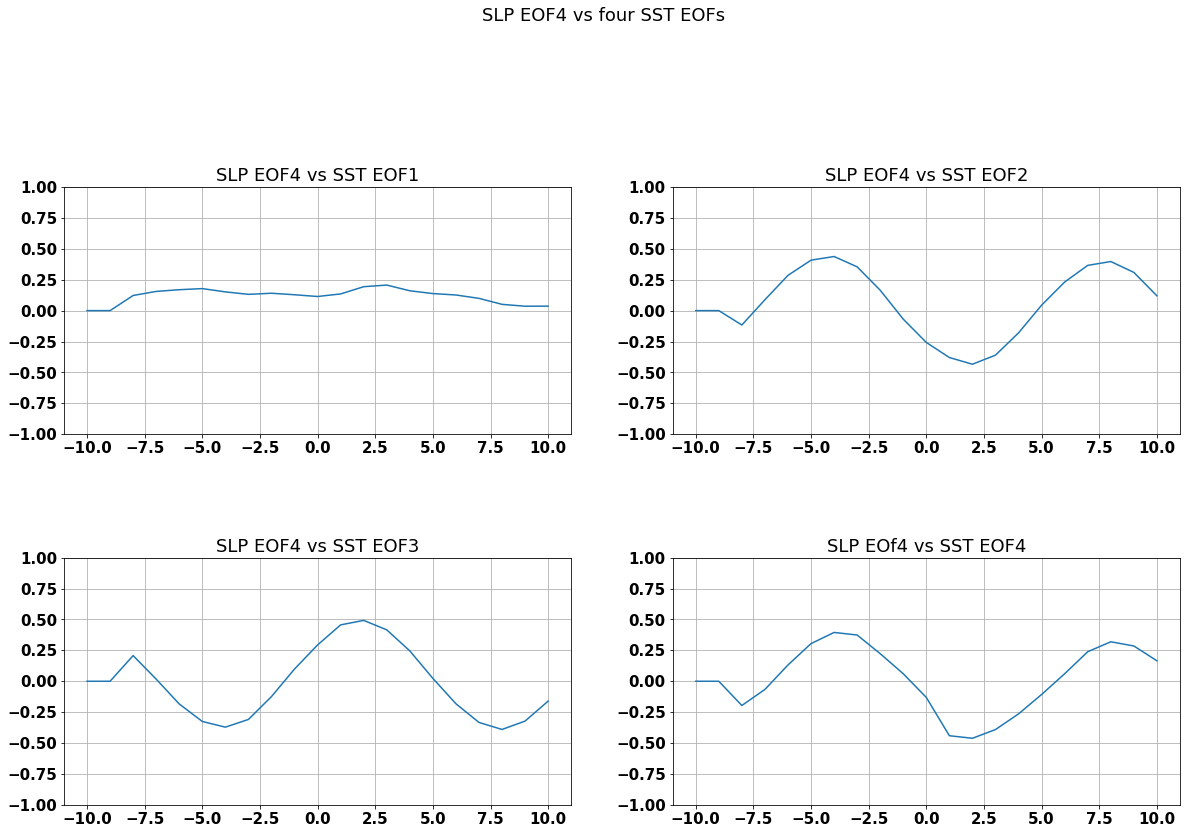

In [37]:
#Plot the cross correlation plot of SLP EOF4 with the four SST EOFs

fig = PP.figure(figsize=(20, 25))
fig.subplots_adjust(hspace=.5)
PP.suptitle('SLP EOF4 vs four SST EOFs')

sub1 = fig.add_subplot(421)
sub1.set_title('SLP EOF4 vs SST EOF1')
PP.plot(range(-10,11,1),corr4_1)
sub1.set_ylim([-1,1])
sub1.grid()

sub2 = fig.add_subplot(422)
sub2.set_title('SLP EOF4 vs SST EOF2')
PP.plot(range(-10,11,1),corr4_2)
sub2.set_ylim([-1,1])
sub2.grid()

sub3 = fig.add_subplot(423)
sub3.set_title('SLP EOF4 vs SST EOF3')
PP.plot(range(-10,11,1),corr4_3)
sub3.set_ylim([-1,1])
sub3.grid()

sub4 = fig.add_subplot(424)
sub4.set_title('SLP EOf4 vs SST EOF4')
PP.plot(range(-10,11,1),corr4_4)
sub4.set_ylim([-1,1])
sub4.grid()

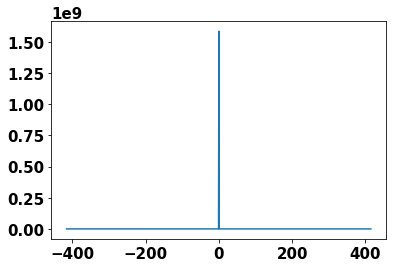

In [19]:
# >>> from scipy.fftpack import fft
# >>> # Number of sample points
# >>> N = 600
# >>> # sample spacing
# >>> T = 1.0 / 800.0
# >>> x = np.linspace(0.0, N*T, N)
# >>> y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# >>> yf = fft(y)
# >>> xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
# >>> import matplotlib.pyplot as plt
# >>> plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# >>> plt.grid()
# >>> plt.show()

import numpy as np
from scipy import fftpack

data = ssteof_ts[0]
# N=len(data)
# T=1/800
# x=np.linspace(0,N*T,N)
# yf=fft(data)
# xf=np.linspace(0,1/(2*T),N/2)

# PP.plot(xf,2/N*np.abs(yf[0:N/2]))
# PP.grid()
# PP.show()


ps = np.abs(np.fft.fft(data))**2
# ps=ps[1:831]

time_step =1.0/len(data)
freqs = np.fft.fftfreq(data.size, time_step)


# freqs=freqs[1:831]
idx = np.argsort(freqs)

PP.plot(freqs[idx], ps[idx])
PP.show()


In [40]:
def spectranalysis(X):
    """
        input:
        ------
            X: signals
            
            
        output:
        -------
        
            ps:power spectrum
            freqs:frequency
    
    """
    # center data around the mean
    X=X-average(X);
    
    # detrend the data
    X=scipy.signal.detrend(X);
    
    # calculate power sepctrum and dthe frequency
    ps=np.abs(np.fft.rfft(X))**2
    freqs=np.fft.rfftfreq(X.size)
    
    return ps,freqs
    
    

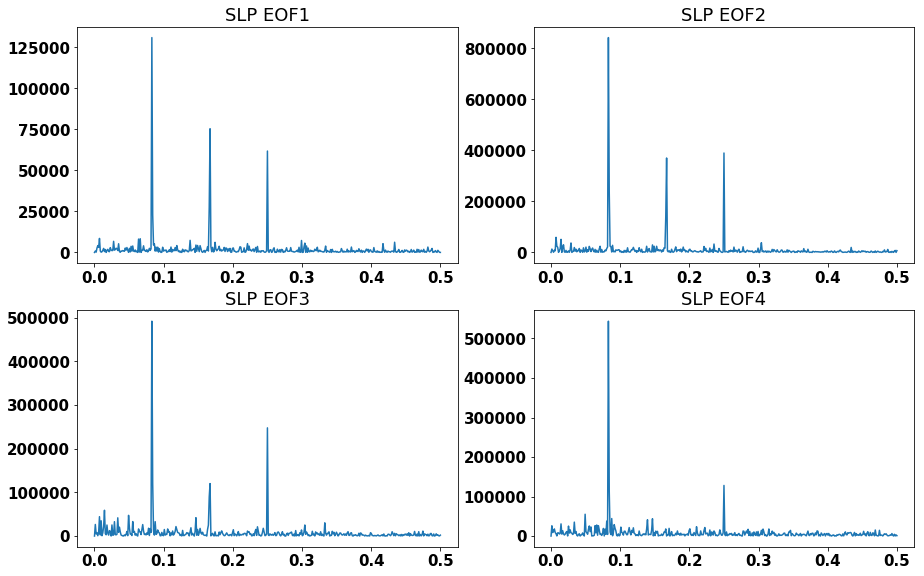

In [50]:
import numpy as np
from scipy import fftpack
import scipy.signal


#Plot the spectral analysis for the four SLP EOFs
ps1, freqs1=spectranalysis(slpeof_ts[0])
ps2, freqs2=spectranalysis(slpeof_ts[1])
ps3, freqs3=spectranalysis(slpeof_ts[2])
ps4, freqs4=spectranalysis(slpeof_ts[3])


fig = PP.figure(figsize=(15, 20))

sub1 = fig.add_subplot(421)
sub1.set_title('SLP EOF1')
PP.plot(freqs1,ps1)

sub2 = fig.add_subplot(422)
sub2.set_title('SLP EOF2')
PP.plot(freqs2,ps2)

sub2 = fig.add_subplot(423)
sub2.set_title('SLP EOF3')
PP.plot(freqs3,ps3)

sub2 = fig.add_subplot(424)
sub2.set_title('SLP EOF4')
PP.plot(freqs4,ps4)

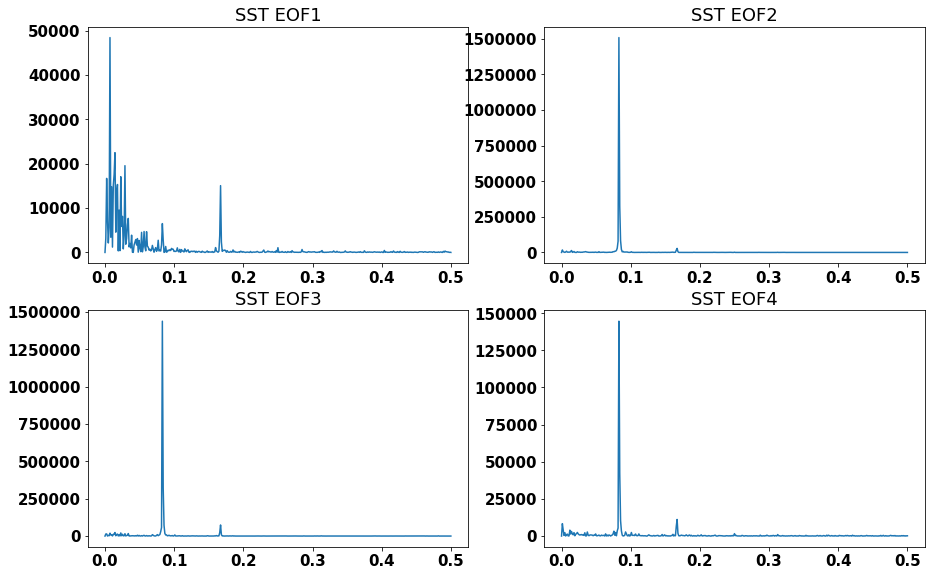

In [51]:
#Plot the spectral analysis for the four SST EOFs

ps1, freqs1=spectranalysis(ssteof_ts[0])
ps2, freqs2=spectranalysis(ssteof_ts[1])
ps3, freqs3=spectranalysis(ssteof_ts[2])
ps4, freqs4=spectranalysis(ssteof_ts[3])


fig = PP.figure(figsize=(15, 20))

sub1 = fig.add_subplot(421)
sub1.set_title('SST EOF1')
PP.plot(freqs1,ps1)

sub2 = fig.add_subplot(422)
sub2.set_title('SST EOF2')
PP.plot(freqs2,ps2)

sub2 = fig.add_subplot(423)
sub2.set_title('SST EOF3')
PP.plot(freqs3,ps3)

sub2 = fig.add_subplot(424)
sub2.set_title('SST EOF4')
PP.plot(freqs4,ps4)